# Image caption generator is a process of recognizing the context of an image and annotating it with relevant captions using deep learning, and computer vision. This is an advanced deep learning project where more than one model must be used for analysis and preprocessing the data to obtain the results. 

## We will use Convolutional Neural Network (CNN) for image feature extraction and Long Short-Term Memory Network (LSTM) for Natural Language Processing (NLP).

In [41]:
import os
import pickle
import numpy as np
#from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# extract image features.

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 83s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112

## Dataset Information
## The objective of the project is to predict the captions for the input image. The dataset consists of 8k images and 5 captions for each image. The features are extracted from both the image and the text captions for input. 


## The features will be concatenated to predict the next word of the caption. CNN is used for image and LSTM is used for text. BLEU Score is used as a metric to evaluate the performance of the trained model.

###  extract the image features and load the data for preprocessing

In [5]:

features = {}
BASE_DIR = os.getcwd()
directory = os.path.join(BASE_DIR, 'Images')

for img_name in os.listdir(directory):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature


In [6]:
pickle.dump(features, open(os.path.join(BASE_DIR, 'features.pkl'), 'wb'))

In [9]:
with open(os.path.join(BASE_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [10]:
# storing the caption data from the text file.
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### splitting and appending the caption data with the images.

In [11]:
mapping = {}
# process lines
for line in captions_doc.split('\n'):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [12]:
len(mapping)

8091

## text data preprocessing

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
clean(mapping)

In [17]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### storing the preprocessed captions in to a list.

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

### no of unique captions

In [19]:
len(all_captions)

40455

In [20]:
all_captions[:20]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas 

## processing the text dataset.

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

### vocabulary size (8485)--> the total number of unique items.

In [22]:
vocab_size

8485

### Getting the maximum leanth of captions available.

In [23]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Train test split.

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### padding sequences.

In [30]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                     
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 
                       num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                if n == batch_size:
                  X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                  yield [X1, X2], y
                  X1, X2, y = list(), list(), list()
                  n = 0

### Model creations.

In [31]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
#se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se1)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [46]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 76s 337ms/step - loss: 1.6252


In [47]:
model.save(BASE_DIR+'/best_model.h5')

## genrating captions for images.

In [48]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [49]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

## validating the data using BLEU score.

In [50]:
#from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in test:
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
#     print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#     print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

## Visualize the predicted captions

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs one with red collar and one brown and white dog playing together endseq


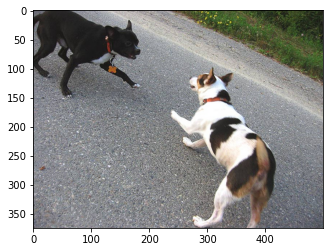

In [51]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in green shirt and headscarf is playing red merry go round in tent surrounded by flowers endseq


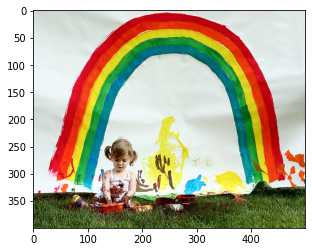

In [52]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq couple stands close at the water 's edge endseq
startseq the two people stand by body of water and in front of bushes in fall endseq
startseq two people hold each other near pond endseq
startseq two people stand by the water endseq
startseq two people stand together on the edge of the water on the grass endseq
--------------------Predicted--------------------
startseq two children are walking along water swing off water 's reflection endseq


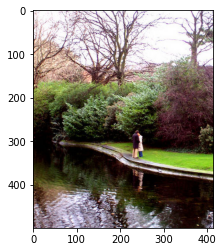

In [53]:
generate_caption('3637013_c675de7705.jpg')

---------------------Actual---------------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse 's lead behind fire endseq
startseq "a man and girl and two horses are near contained fire ." endseq
startseq two people and two horses watching fire endseq
--------------------Predicted--------------------
startseq girl in green sweatshirt with brown horse and other blonde girl are staring at the lead as woman wearing green sweatshirt looks out endseq


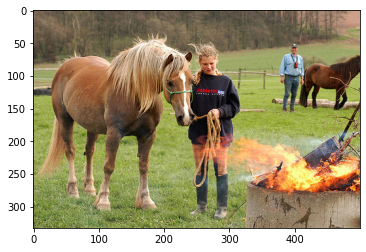

In [54]:
generate_caption('10815824_2997e03d76.jpg')

---------------------Actual---------------------
startseq group of people stand in the sand looking out at the water endseq
startseq five people look out toward the ocean endseq
startseq five people standing in front of body of water endseq
startseq three men and two women stand facing the ocean from the shore on sunny day endseq
startseq two ladies and three men looking at the ocean endseq
--------------------Predicted--------------------
startseq man and woman are standing on rail by the ocean endseq


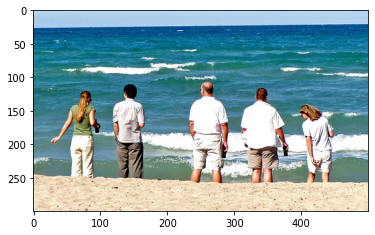

In [55]:
generate_caption('160792599_6a7ec52516.jpg')

# finally the model predicted the most accurate caption from the image.